In [2]:
# retrieval cloud amount
# initial built: 2024/12/16

import netCDF4 as nc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [22]:
file_dir = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/amsua/full_clr_clr_and_cld_cld_0.05_varbcpred_obs_cld'
ncfile   = 'diag_amsua_n18_ges.2022080500.nc4'

In [23]:
fn     = nc.Dataset(f'{file_dir}/{ncfile}')

# read ncfile:
obs       = fn.variables['Observation'][:]
omf       = fn.variables['Obs_Minus_Forecast_adjusted'][:]
omfnbc    = fn.variables['Obs_Minus_Forecast_unadjusted'][:]
tb    = obs - omf
tbnbc = obs - omfnbc
clw_obs   = fn.variables['clw_obs'][:]
clw_model = fn.variables['clw_guess_retrieval'][:]
clw_model_nobc = fn.variables['clw_guess_retrieval_nobc'][:]
fwater    = fn.variables['Water_Fraction'][:]
ch        = fn.variables['Channel_Index'][:]
qc        = fn.variables['QC_Flag'][:]
bccnst    = fn.variables['BC_Constant'][:]
varbc_idx = fn.variables['VarBC_Data_Control_Index'][:]

In [24]:
use1 = np.where( (qc == 0)&(ch==1)&(fwater>=0.99)&(varbc_idx==1) )

In [25]:
tb_use = [];
tbnbc_use = [];
cloud_use = [];
cloudnbc_use = [];

num_sample=0
for i in use1[0]:
    # make sure for the same obs, channel 2 is also in use
    use2 = (qc[i+1]==0)
    if not use2:
        continue
    tb_use.append([tb[i], tb[i+1]])
    tbnbc_use.append([tbnbc[i], tbnbc[i+1]])
    cloud_use.append(clw_model[i])
    cloudnbc_use.append(clw_model_nobc[i])
    num_sample+=1
    
tb_arr    = np.array(tb_use)
tbnbc_arr = np.array(tbnbc_use)
cld_arr   = np.array(cloud_use)
cldnbc_arr= np.array(cloudnbc_use)

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.400e+01, 4.840e+02, 1.710e+03,
        1.143e+03, 4.580e+02, 1.640e+02, 6.700e+01, 2.800e+01, 2.600e+01,
        1.700e+01, 4.000e+00, 8.000e+00, 4.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
         0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
         0.26,  0.28,  0.3 ]),
 <BarContainer object of 20 artists>)

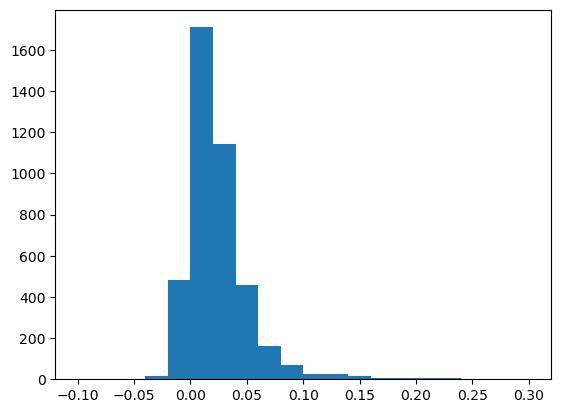

In [21]:
plt.hist(cld_arr - cldnbc_arr, bins=np.linspace(-0.1,0.3,21))

In [16]:
np.mean(cld_arr - cldnbc_arr)

0.008060123

In [116]:
np.mean(cloud_arr,axis=0)

array([181.32204, 167.84055], dtype=float32)

In [117]:
np.mean(cloud_nobc_arr,axis=0)

array([180.56934, 167.16582], dtype=float32)

In [68]:
max(cloud_arr[:,0])


235.63551

In [69]:
max(cloud_arr[:,1])


207.70938

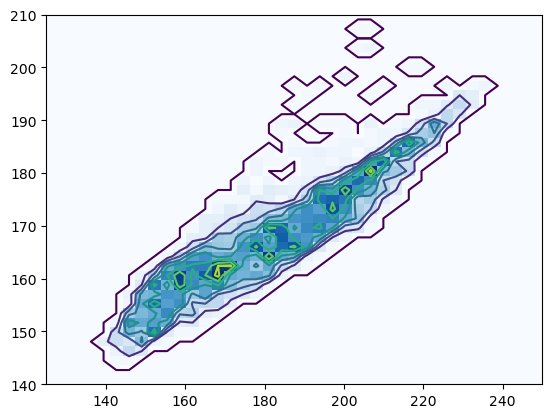

In [107]:
tb1_range = np.linspace(125,250,40)
tb2_range = np.linspace(140,210,40)

h = plt.hist2d(cloud_arr[:,0], cloud_arr[:,1], bins=[tb1_range, tb2_range], cmap='Blues')
x = 0.5*(h[1][:-1] + h[1][1:])
y = 0.5*(h[2][:-1] + h[2][1:])
[xx,yy] = np.meshgrid(x,y)

plt.contour(xx,yy,h[0].T)

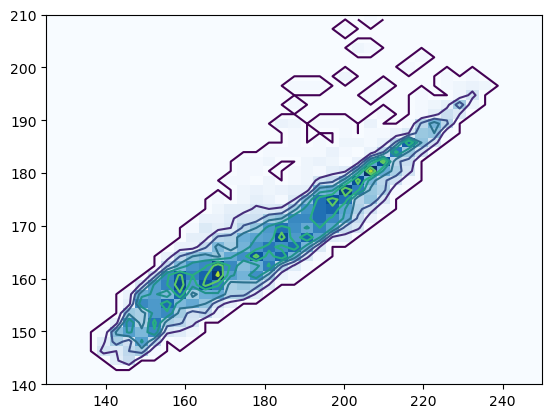

In [108]:

h_nobc = plt.hist2d(cloud_nobc_arr[:,0], cloud_nobc_arr[:,1], bins=[tb1_range, tb2_range], cmap='Blues')
x = 0.5*(h[1][:-1] + h[1][1:])
y = 0.5*(h[2][:-1] + h[2][1:])
[xx,yy] = np.meshgrid(x,y)

plt.contour(xx,yy,h_nobc[0].T)

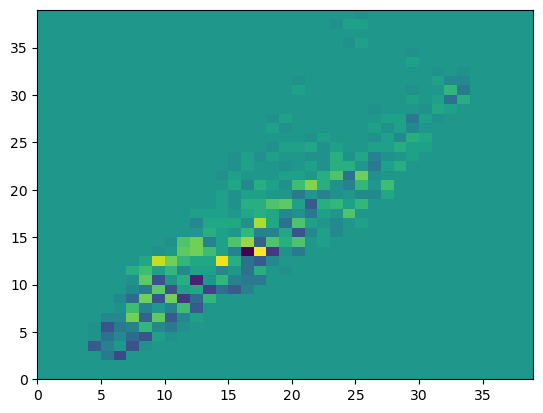

In [109]:
plt.pcolormesh(h[0].T-h_nobc[0].T)

In [99]:
h[0][25,:]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  3.,  8., 18., 17., 21., 44., 24.,  3.,  1.,
        1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.])

In [110]:
def ret_amsua(tb_ch1, tb_ch2, zasat):
    # tb_ch1: brightness temperature of channel 1
    # tb_ch2: brightness temperature of channel 2
    # zasat: zenith angle
    
    coszat = np.cos(np.radians(zasat))
    d0 = 8.240 - (2.622 - 1.846*coszat)*coszat
    d1 = 0.754
    d2 = -2.265
    
    ret_cld=coszat*(d0 + d1*np.log(285-tb_ch1) + d2*np.log(285-tb_ch2))
    
    return max(0,ret_cld)

In [111]:

[tb11, tb22] = np.meshgrid(tb1_range, tb2_range)

ret_clw = np.zeros_like(tb11)
for i, tb1 in enumerate(tb1_range):
    for j, tb2 in enumerate(tb2_range):
        ret_clw[i,j] = ret_amsua(tb1,tb2,0)

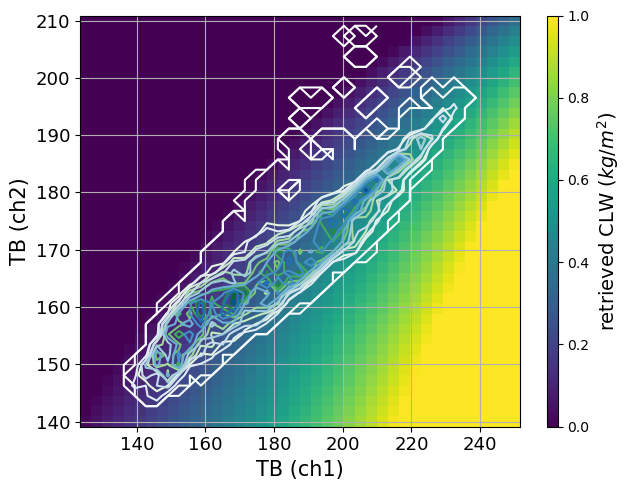

In [113]:
save_figure = False

vmin = 0
vmax = 1

fig, ax = plt.subplots(figsize=(6.5,5.0))
contour = ax.pcolormesh(tb11, tb22, ret_clw, cmap='viridis', vmin=vmin, vmax=vmax)

ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('TB (ch1)', fontsize=15)
ax.set_ylabel('TB (ch2)', fontsize=15)

ax.grid(True)
#ax.set_title(rf'{sensor} [{chanl}] $\Delta T_B$ from cloud',fontsize=16)

cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label(r'retrieved CLW ($kg/m^2$)',fontsize=14)

ax.contour(xx,yy,h[0].T, cmap='Greens')
ax.contour(xx,yy,h_nobc[0].T, cmap='Blues')

plt.tight_layout()
if save_figure:
    plt.savefig(f"cloud_pred_obs_timeseries_{sensor}_{chanl}.png")